In [28]:
import numpy as np
import sys

# Settings for ACSF calculations

GEOM_FILE = "random_water_mono-100-train.xyz" # input geoms of water clusters

# ACSF parameters
Rc0 = 6.0 # cut-off radius
par_g2 = [[1, 1], [1, 2], [1, 3]] # eta, Rs
par_g3 = [] # kappa
par_g4 = [[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]] # eta, zeta, lambda
par_g5 = [] # eta, zeta, lambda

# End settings

# prepare ACSF paramters
eta2 = []
Rs = []
kappa = []
eta4 = []
zeta4 = []
lmbd4 = []
eta5 = []
zeta5 = []
lmbd5 = []

for ii in par_g2:
    eta2.append(ii[0])
    Rs.append(ii[1])

for ii in par_g3:
    kappa.append(ii)
    
for ii in par_g4:
    eta4.append(ii[0])
    zeta4.append(ii[1])
    lmbd4.append(ii[2])
    
for ii in par_g5:
    eta5.append(ii[0])
    zeta5.append(ii[1])
    lmbd5.append(ii[2])

# read cluster structures in a stacked xyz file
# strucs is a list of molecular cluster structures
# each structure is an array of atomic labels and coordinates (as array)
strucs = []
struc = []
with open(GEOM_FILE, "r") as INPUT:
    for line in INPUT:
        line_sp = line.split()
        if len(line_sp) == 1:
            if len(struc) != 0:
                strucs.append(struc)
            struc = []
        if len(line_sp) == 4:
            struc.append([line_sp[0], np.asarray([float(line_sp[1]), float(line_sp[2]), float(line_sp[3])])])
            
strucs.append(struc)

# Define various ACSFs
# cutoff function
def fc(R, Rc=Rc0):
    if R <= Rc:
        return 0.5*(np.cos(np.pi*R/Rc) + 1.0)
    else:
        return 0
    
# G2 radial function
def G2_r(R, eta2, Rs):
    G2 = []
    if len(eta2) != len(Rs):
        print("Parameter dimensions do not match in G2_r!")
        sys.exit()
    for i in range(len(eta2)):
        G2.append(np.exp(-eta2[i]*(R - Rs[i])**2) * fc(R))
    return G2

# G3 radial function
def G3_r(R, kappa):
    G3 = []
    for i in range(len(kappa)):
        G3.append(np.cos(kappa[i] * R) * fc(R))
    return G3

# G4 angular function
def G4_r(eta4, zeta4, lmbd4, Rij, Rik, Rjk):
    if (len(eta4) != len(zeta4)) or (len(eta4) != len(lmbd4)) or (len(zeta4) != len(lmbd4)):
        print("Parameter dimensions do not match in G4_r!")
        sys.exit()
    cos_theta = 0.5 * (Rij**2 + Rik**2 - Rjk**2)/(Rij*Rik)
    G4 = []
    for i in range(len(eta4)):
        G4.append((2.0)**(1.0 - zeta4[i]) *(1.0 + lmbd4[i] * cos_theta)**zeta4[i] * \
            np.exp(-eta4[i]*(Rij**2 + Rik**2 + Rjk**2)) * fc(Rij) * \
            fc(Rik) * fc(Rjk))
    return G4

# G5 angular function
def G5_r(eta5, zeta5, lmbd5, Rij, Rik, Rjk):
    if (len(eta5) != len(zeta5)) or (len(eta5) != len(lmbd5)) or (len(zeta5) != len(lmbd5)):
        print("Parameter dimensions do not match in G5_r!")
        sys.exit()
    cos_theta = 0.5 * (Rij**2 + Rik**2 - Rjk**2)/(Rij*Rik)
    G5 = []
    for i in range(len(eta5)):
        G5.append((2.0)**(1.0 - zeta5[i]) *(1.0 + lmbd5[i] * cos_theta)**zeta5[i] * \
            np.exp(-eta5[i]*(Rij**2 + Rik**2)) * fc(Rij) * \
            fc(Rik))
    return G5

# utility: calculate the distance between two atoms
def dist(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)

# utility: adding two arrays
def array_add(arr1, arr2):
    if len(arr1) != len(arr2):
        print("Input dimensions not match in array_add()!")
        sys.exit()
    sum = []
    for i in range(len(arr1)):
        sum.append(arr1[i] + arr2[i])
    return sum

# calculate ACSCFs for each atom in all structures
calc_g3 = True
calc_g5 = True

if len(kappa) == 0:
    calc_g3 = False

if len(eta5) == 0:
    calc_g5 = False

strucs_G = []

for cluster in strucs:
    struc_G = []
    no_atoms = len(cluster)
    for i in range(no_atoms):
        G1 = 0
        G2 = [0 for ii in eta2]
        G3 = [0 for ii in kappa]
        G4 = [0 for ii in eta4]
        G5 = [0 for ii in eta5]
        for j in range(no_atoms):
            if j != i:
                # calculate Rij
                Rij = dist(cluster[i][1], cluster[j][1])
                G1 += fc(Rij) # calculate G1
                G2 = array_add(G2, G2_r(Rij, eta2, Rs)) # calculate G2
                if calc_g3:
                    G3 = array_add(G3, G3_r(Rij, kappa)) # calculate G3 when necessary
                for k in range(no_atoms):
                    if k != i and k !=j:
                    # calculate Rik, Rjk
                        Rik = dist(cluster[i][1], cluster[k][1])
                        Rjk = dist(cluster[j][1], cluster[k][1])
                        G4 = array_add(G4, G4_r(eta4, zeta4, lmbd4, Rij, Rik, Rjk)) # calculate G4
                        if calc_g5:
                            G5 = array_add(G5, G5_r(eta5, zeta5, lmbd5, Rij, Rik, Rjk))
        struc_G.append([cluster[i][0], np.concatenate([[G1], G2, G3, G4, G5])])
    strucs_G.append(struc_G)
    
# now the calculated ACSFs are in the array component of strucs_G
# strucs_G[i] points to the i-th cluster
# strucs_G[i][j] the j-th atom of cluster i and its Gs, in the structure of 'atom label', array[G1, G2,...,G5]

In [29]:
strucs_G[1]

[['O',
  array([1.87470216, 1.8716816 , 0.64400122, 0.03004367, 0.017743  ,
         0.00681001, 0.02848511, 0.01755212])],
 ['H',
  array([1.78501767e+00, 1.58541649e+00, 1.00881013e+00, 1.10581247e-01,
         4.15065418e-02, 3.72672188e-02, 4.72156615e-03, 4.82243117e-04])],
 ['H',
  array([1.79046939e+00, 1.58813451e+00, 9.82084142e-01, 1.08048592e-01,
         4.10038904e-02, 3.63700593e-02, 5.22421760e-03, 5.90386472e-04])]]

In [134]:
# Define the molecular cluster NN

import torch
import collections

torch.set_default_dtype(torch.float64)

# Settings
n_hiddens_H = 3
n_hiddens_O = 3
n_hidden_H = 32
n_hidden_O = 64
n_out_H = 1
n_out_O = 1
activation_H = 'sigmoid'
activation_O = 'sigmoid'

# End settings

no_atom_inputs = len(strucs_G[0][0][1])

class AtomicNet(torch.nn.Module):
    """A simple feed-forward network with variable structure, randomly
    initialized weights, choosable activation and a linear output layer.
    """
    def __init__(self, n_features, n_hiddens, n_hidden, n_out, activation):
        super(AtomicNet, self).__init__()
        self.n_hiddens = n_hiddens
        if activation.lower() == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation.lower() == 'sigmoid': 
            self.activation = torch.nn.Sigmoid()
        elif activation.lower() == 'tanh': 
            self.activation = torch.nn.Tahn()
        else:
            print("Activation function not recoginized!")
            sys.exit(1)
        func_ordered_dict = collections.OrderedDict()
        func_ordered_dict['input'] = torch.nn.Linear(n_features, n_hidden)
        func_ordered_dict['act0'] = self.activation
        for i in range(n_hiddens):
            func_ordered_dict['hidden'+str(i+1)] = torch.nn.Linear(n_hidden, n_hidden)
            func_ordered_dict['act'+str(i+1)] = self.activation
        func_ordered_dict['out'] = torch.nn.Linear(n_hidden, n_out)
        self.linear_act_stack = torch.nn.Sequential(func_ordered_dict)

    def forward(self, x):
        x = self.linear_act_stack(x)
                                               
        return x

class ClusterModel(torch.nn.Module):
    def __init__(self, cluster):
        super(ClusterModel, self).__init__()
        self.cluster = cluster
        self.NN_H = AtomicNet(no_atom_inputs, n_hiddens_H, n_hidden_H, n_out_H, activation_H)
        self.NN_O = AtomicNet(no_atom_inputs, n_hiddens_O, n_hidden_O, n_out_O, activation_O)
        
    def forward(self, cluster):
        E_cluster = 0
        for atom in cluster:
            if atom[0] == 'O':
                G_O = torch.from_numpy(atom[1])
                E_O = self.NN_O(G_O)
                E_cluster += E_O
            else:
                G_H = torch.from_numpy(atom[1])
                E_H = self.NN_H(G_H)
                E_cluster += E_H        
#             E_clusters.append(E_cluster.detach())
#         return torch.asarray(E_clusters, requires_grad = True)
        return E_cluster
    
    
mymodel = ClusterModel(strucs_G_train_1000[0])
print(mymodel)
mymodel.to(device) # asign model to GPU or CPU

ClusterModel(
  (NN_H): AtomicNet(
    (activation): Sigmoid()
    (linear_act_stack): Sequential(
      (input): Linear(in_features=8, out_features=32, bias=True)
      (act0): Sigmoid()
      (hidden1): Linear(in_features=32, out_features=32, bias=True)
      (act1): Sigmoid()
      (hidden2): Linear(in_features=32, out_features=32, bias=True)
      (act2): Sigmoid()
      (hidden3): Linear(in_features=32, out_features=32, bias=True)
      (act3): Sigmoid()
      (out): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (NN_O): AtomicNet(
    (activation): Sigmoid()
    (linear_act_stack): Sequential(
      (input): Linear(in_features=8, out_features=64, bias=True)
      (act0): Sigmoid()
      (hidden1): Linear(in_features=64, out_features=64, bias=True)
      (act1): Sigmoid()
      (hidden2): Linear(in_features=64, out_features=64, bias=True)
      (act2): Sigmoid()
      (hidden3): Linear(in_features=64, out_features=64, bias=True)
      (act3): Sigmoid()
      (out): 

ClusterModel(
  (NN_H): AtomicNet(
    (activation): Sigmoid()
    (linear_act_stack): Sequential(
      (input): Linear(in_features=8, out_features=32, bias=True)
      (act0): Sigmoid()
      (hidden1): Linear(in_features=32, out_features=32, bias=True)
      (act1): Sigmoid()
      (hidden2): Linear(in_features=32, out_features=32, bias=True)
      (act2): Sigmoid()
      (hidden3): Linear(in_features=32, out_features=32, bias=True)
      (act3): Sigmoid()
      (out): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (NN_O): AtomicNet(
    (activation): Sigmoid()
    (linear_act_stack): Sequential(
      (input): Linear(in_features=8, out_features=64, bias=True)
      (act0): Sigmoid()
      (hidden1): Linear(in_features=64, out_features=64, bias=True)
      (act1): Sigmoid()
      (hidden2): Linear(in_features=64, out_features=64, bias=True)
      (act2): Sigmoid()
      (hidden3): Linear(in_features=64, out_features=64, bias=True)
      (act3): Sigmoid()
      (out): 

In [133]:
# torch.cuda.is_available() # to check if GPU is available

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

# only one GPU: NVIDIA GeForce GTX 1070 is available
# for i in range(torch.cuda.device_count()):
#     print(torch.cuda.get_device_properties(i).name)

cpu


In [3]:
# define a function to calculate ACSFs for a bunch of geoms

def clusers_ACSF(ClustersGeom):
    # ACSF parameters
    Rc0 = 6.0 # cut-off radius
    par_g2 = [[1, 1], [1, 2], [1, 3]] # eta, Rs
    par_g3 = [] # kappa
    par_g4 = [[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]] # eta, zeta, lambda
    par_g5 = [] # eta, zeta, lambda

    # End settings

    # prepare ACSF paramters
    eta2 = []
    Rs = []
    kappa = []
    eta4 = []
    zeta4 = []
    lmbd4 = []
    eta5 = []
    zeta5 = []
    lmbd5 = []

    for ii in par_g2:
        eta2.append(ii[0])
        Rs.append(ii[1])

    for ii in par_g3:
        kappa.append(ii)
    
    for ii in par_g4:
        eta4.append(ii[0])
        zeta4.append(ii[1])
        lmbd4.append(ii[2])
    
    for ii in par_g5:
        eta5.append(ii[0])
        zeta5.append(ii[1])
        lmbd5.append(ii[2])

    strucs = []
    struc = []
    with open(ClustersGeom, "r") as INPUT:
        for line in INPUT:
            line_sp = line.split()
            if len(line_sp) == 1:
                if len(struc) != 0:
                    strucs.append(struc)
                struc = []
            if len(line_sp) == 4:
                struc.append([line_sp[0], np.asarray([float(line_sp[1]), float(line_sp[2]), float(line_sp[3])])])
            
    strucs.append(struc)

    def fc(R, Rc=Rc0):
        if R <= Rc:
            return 0.5*(np.cos(np.pi*R/Rc) + 1.0)
        else:
            return 0
    
    # G2 radial function
    def G2_r(R, eta2, Rs):
        G2 = []
        if len(eta2) != len(Rs):
            print("Parameter dimensions do not match in G2_r!")
            sys.exit()
        for i in range(len(eta2)):
            G2.append(np.exp(-eta2[i]*(R - Rs[i])**2) * fc(R))
        return G2

    # G3 radial function
    def G3_r(R, kappa):
        G3 = []
        for i in range(len(kappa)):
            G3.append(np.cos(kappa[i] * R) * fc(R))
        return G3

    # G4 angular function
    def G4_r(eta4, zeta4, lmbd4, Rij, Rik, Rjk):
        if (len(eta4) != len(zeta4)) or (len(eta4) != len(lmbd4)) or (len(zeta4) != len(lmbd4)):
            print("Parameter dimensions do not match in G4_r!")
            sys.exit()
        cos_theta = 0.5 * (Rij**2 + Rik**2 - Rjk**2)/(Rij*Rik)
        G4 = []
        for i in range(len(eta4)):
            G4.append((2.0)**(1.0 - zeta4[i]) *(1.0 + lmbd4[i] * cos_theta)**zeta4[i] * \
                np.exp(-eta4[i]*(Rij**2 + Rik**2 + Rjk**2)) * fc(Rij) * \
                fc(Rik) * fc(Rjk))
        return G4

    # G5 angular function
    def G5_r(eta5, zeta5, lmbd5, Rij, Rik, Rjk):
        if (len(eta5) != len(zeta5)) or (len(eta5) != len(lmbd5)) or (len(zeta5) != len(lmbd5)):
            print("Parameter dimensions do not match in G5_r!")
            sys.exit()
        cos_theta = 0.5 * (Rij**2 + Rik**2 - Rjk**2)/(Rij*Rik)
        G5 = []
        for i in range(len(eta5)):
            G5.append((2.0)**(1.0 - zeta5[i]) *(1.0 + lmbd5[i] * cos_theta)**zeta5[i] * \
                np.exp(-eta5[i]*(Rij**2 + Rik**2)) * fc(Rij) * \
                fc(Rik))
        return G5

    # utility: calculate the distance between two atoms
    def dist(coord1, coord2):
        return np.linalg.norm(coord1 - coord2)

    # utility: adding two arrays
    def array_add(arr1, arr2):
        if len(arr1) != len(arr2):
            print("Input dimensions not match in array_add()!")
            sys.exit()
        sum = []
        for i in range(len(arr1)):
            sum.append(arr1[i] + arr2[i])
        return sum

    # calculate ACSCFs for each atom in all structures
    calc_g3 = True
    calc_g5 = True

    if len(kappa) == 0:
        calc_g3 = False

    if len(eta5) == 0:
        calc_g5 = False

    strucs_G = []

    for cluster in strucs:
        struc_G = []
        no_atoms = len(cluster)
        for i in range(no_atoms):
            G1 = 0
            G2 = [0 for ii in eta2]
            G3 = [0 for ii in kappa]
            G4 = [0 for ii in eta4]
            G5 = [0 for ii in eta5]
            for j in range(no_atoms):
                if j != i:
                    # calculate Rij
                    Rij = dist(cluster[i][1], cluster[j][1])
                    G1 += fc(Rij) # calculate G1
                    G2 = array_add(G2, G2_r(Rij, eta2, Rs)) # calculate G2
                    if calc_g3:
                        G3 = array_add(G3, G3_r(Rij, kappa)) # calculate G3 when necessary
                    for k in range(no_atoms):
                        if k != i and k !=j:
                        # calculate Rik, Rjk
                            Rik = dist(cluster[i][1], cluster[k][1])
                            Rjk = dist(cluster[j][1], cluster[k][1])
                            G4 = array_add(G4, G4_r(eta4, zeta4, lmbd4, Rij, Rik, Rjk)) # calculate G4
                            if calc_g5:
                                G5 = array_add(G5, G5_r(eta5, zeta5, lmbd5, Rij, Rik, Rjk))
            struc_G.append([cluster[i][0], np.concatenate([[G1], G2, G3, G4, G5])])
        strucs_G.append(struc_G)
        
    return strucs_G

In [4]:
# prepare the training (100 data points) and testing reference data
energies = []
with open("random_water_train_100-sp.dat", "r") as Target:
    for line in Target:
        line_sp = line.split()
        energies.append(float(line_sp[1]))

trans_e_100_train = [-1000*(e + 76.40) for e in energies]
trans_e_100_train = torch.from_numpy(np.asarray(trans_e_100_train))

energies = []
with open("random_water_test20-sp.dat", "r") as Target:
    for line in Target:
        line_sp = line.split()
        energies.append(float(line_sp[1]))

trans_e_test = [-1000*(e + 76.40) for e in energies]
trans_e_test = torch.from_numpy(np.asarray(trans_e_test))

strucs_G_test = clusers_ACSF('random_water_mono-20-test.xyz')

In [70]:
# prepare 1000 training data points
energies = []
with open("random_water_train_1000-sp.dat", "r") as Target:
    for line in Target:
        line_sp = line.split()
        energies.append(float(line_sp[1]))

trans_e_1000_train = [-1000*(e + 76.40) for e in energies]
trans_e_1000_train = torch.from_numpy(np.asarray(trans_e_1000_train))

strucs_G_train_1000 = clusers_ACSF('random_water_mono-1000-train.xyz')

In [482]:
import sys
# Fit

# strucs_G_train_1000.to(device)

# move list to GPU
# strucs_G_gpu = torch.tensor(strucs_G_train_1000)
# strucs_G_gpu.to(device)

#load saved model
# with open('NN-water_mono-E-tmp.pkl', 'rb') as f:
#     mymodel = pickle.load(f)

# loss function
def f_loss(E_pred, E_train):
    loss = torch.nn.MSELoss()
    return loss(E_pred, E_train)

# Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr=3e-4)

epochs = 1000

for t in range(epochs):
    # Zero the gradients before running the backward pass.
    mymodel.zero_grad()
    e_clusters = torch.empty(0)
    for struc in strucs_G_train_1000:
        E_pred = mymodel(struc)
        e_clusters = torch.cat((e_clusters, E_pred))
        
#     print(E_pred.size())
#     print(trans_e_100_train.size())
#     sys.exit()
#     e_clusters = torch.from_numpy(e_clusters)
    loss = f_loss(e_clusters, trans_e_1000_train)
    
    if (t+1) % 100 == 0:
        print(t, loss.item())

    loss.backward()
    optimizer.step()

99 0.014025985964308388
199 0.013582556206716825
299 0.013403787350431745
399 0.01325760024518475
499 0.013144119342027943
599 0.013058759481071477
699 0.012995874966085313
799 0.012950502843594905
899 0.012918204939966104
999 0.012895083888762414


In [483]:
import pickle

# current NN structure: AtomNN_H: 8*32*32*32*1, AtomNN_O: 8*64*64*64*1
# loss ~ 0.01290
with open('NN-water_mono-E-tmp.pkl','wb') as f:
    pickle.dump(mymodel,f)

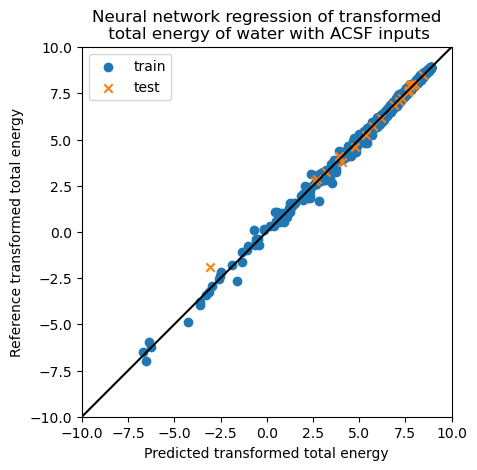

In [428]:
# Show the training and testing results

import matplotlib.pyplot as plt

trans_e_pred_1000_train = []

for struc in strucs_G_train_1000:
    trans_e_pred_1000_train.append(mymodel.forward(struc).detach())
    
trans_e_pred_1000_train = np.asarray(trans_e_pred_1000_train)

trans_e_pred_test = []

for struc in strucs_G_test:
    trans_e_pred_test.append(mymodel.forward(struc).detach())
    
trans_e_pred_test = np.asarray(trans_e_pred_test)
# trans_e_pred_test = mymodel.forward(strucs_G_test)

# print(trans_e_pred_test.size(),trans_e_test.size())

# sys.exit()

# plt.scatter(trans_e_pred_100_train.detach().cpu().numpy(), trans_e_100_train, marker = "o", label = "train")
plt.scatter(trans_e_pred_1000_train, trans_e_1000_train, marker = "o", label = "train")
# plt.scatter(trans_e_pred_test.detach().cpu().numpy(), trans_e_test, marker = "x", label = "test")
plt.scatter(trans_e_pred_test, trans_e_test, marker = "x", label = "test")
plt.plot(range(-10,11), range(-10,11), color = "black") # the digonal line for reference
plt.xlabel("Predicted transformed total energy")
plt.ylabel("Reference transformed total energy")
plt.legend()
plt.title("Neural network regression of transformed\n total energy of water with ACSF inputs")
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.0)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

plt.show()